In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

# score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [20]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
 model.add(Dense(60, activation='relu'))
#  model.add(Dense(20, activation='relu'))
 model.add(Dropout(rate=0.2))
 model.add(Dense(10, activation='relu'))
 model.add(Dense(1))
 # Compile model
 model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
 return model

In [42]:
data = pd.read_csv('NF_Descriptors.csv')
data = data.dropna()
y = data['LUMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [21]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 20, 'epochs': 100}
CV score for GS 0.8230442262731039
Train AUC ROC Score for GS:  0.8747921080114418
Test AUC ROC Score for GS:  0.868978255295895
Train Mean Absolute Error: 33399    0.068771
33689    0.296220
15746    0.143852
29123    0.020671
7868     0.125064
           ...   
28017    0.047339
50496    0.115201
29199    0.356961
40061    0.141767
17673    0.150412
Name: LUMO_calc, Length: 41004, dtype: float64 degrees.
Test Mean Absolute Error: 29860    0.080377
46773    0.328464
35540    0.687901
42760    0.075365
19319    0.078352
           ...   
27088    0.350704
26941    0.067178
46093    0.041595
19342    0.443944
47488    0.731802
Name: LUMO_calc, Length: 10252, dtype: float64 degrees.
Train R2:  0.8228664563531438
Test R2:  0.8112377462641004
Train MSE:  0.05240812612508098
Test MSE:  0.05617896455023825


In [4]:
def create_new_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.2))
 model.add(BatchNormalization())
 model.add(Dense(10, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 # Compile model
 opt = optimizers.Adam(learning_rate=0.003)
 model.compile(loss='MeanSquaredError', optimizer=opt, metrics=['accuracy'])
 return model

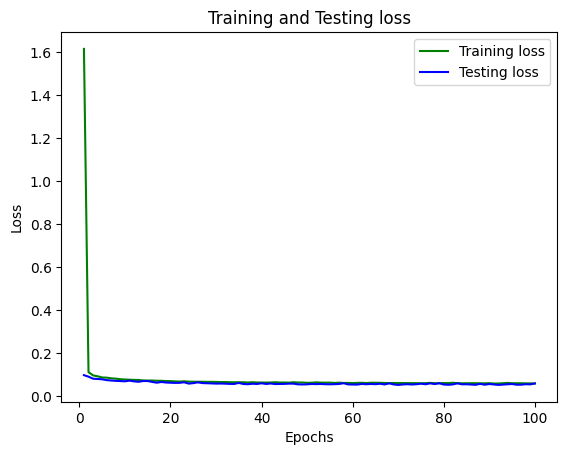

In [46]:
model = KerasRegressor(model=create_new_model, verbose=0)
model.fit(X_train, y_train, epochs=100, batch_size=80, validation_data=(X_test, y_test))
loss_train = model.history_['loss']
loss_val = model.history_['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_new_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sciker

Param for GS {'batch_size': 60, 'epochs': 100}
CV score for GS 0.8135075335597777
Train AUC ROC Score for GS:  0.8699116216989918
Test AUC ROC Score for GS:  0.8666062874459504
Train Mean Absolute Error: 14882    0.140893
41370    0.030794
14014    0.131818
44832    0.527653
30304    0.463192
           ...   
13961    0.211130
48611    0.100115
46854    0.117040
46421    0.001743
40886    0.232520
Name: LUMO_calc, Length: 32803, dtype: float64 degrees.
Test Mean Absolute Error: 29860    0.104800
46773    0.513670
35540    0.752827
42760    0.033735
19319    0.210307
           ...   
27088    0.484845
26941    0.142437
46093    0.027999
19342    0.348607
47488    0.640484
Name: LUMO_calc, Length: 10252, dtype: float64 degrees.
Train R2:  0.8297366170439169
Test R2:  0.822129317095095
Train MSE:  0.05036244080672253
Test MSE:  0.05293744163185362


In [5]:
data = pd.read_csv('NF_Descriptors.csv')
data = data.dropna()
y = data['LUMO_calc']
X = data.loc[:, ['Max Partial Charge', 'NO Count','H Count',
         'C Count', 'N Count', 'Double Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [7]:
def create_alt_model():
 # create model
 model = Sequential()
 model.add(Dense(6, input_shape=(6,), activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(6, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.2))
 model.add(BatchNormalization())
 model.add(Dense(2, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 # Compile model
 opt = optimizers.Adam(learning_rate=0.003)
 model.compile(loss='MeanSquaredError', optimizer=opt, metrics=['accuracy'])
 return model

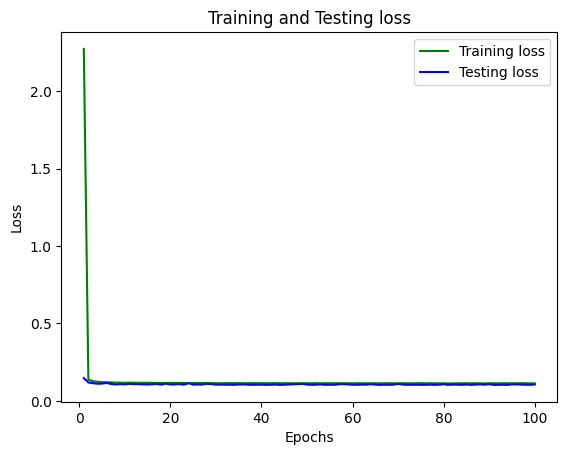

In [9]:
model = KerasRegressor(model=create_alt_model, verbose=0)
model.fit(X_train, y_train, epochs=100, batch_size=80, validation_data=(X_test, y_test))
loss_train = model.history_['loss']
loss_val = model.history_['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_alt_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 80, 'epochs': 100}
CV score for GS 0.6493078382525238
Train AUC ROC Score for GS:  0.808287767097978
Test AUC ROC Score for GS:  0.8070828604161722
Train Mean Absolute Error: 33399    0.348214
33689    0.176154
15746    0.096442
29123    0.348325
7868     0.271313
           ...   
28017    0.145056
50496    0.265368
29199    0.000882
40061    0.224427
17673    0.354450
Name: LUMO_calc, Length: 41004, dtype: float64 degrees.
Test Mean Absolute Error: 29860    0.150072
46773    0.451150
35540    0.718411
42760    0.152802
19319    0.235493
           ...   
27088    0.529064
26941    0.075717
46093    0.060632
19342    0.418348
47488    0.556230
Name: LUMO_calc, Length: 10252, dtype: float64 degrees.
Train R2:  0.659798845416507
Test R2:  0.6591813904648437
Train MSE:  0.10065459455186772
Test MSE:  0.10143360870190549
